In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from pygdsm import GlobalSkyModel16

%matplotlib widget

In [2]:
b = np.load("/home/christian/Documents/research/eigsep/eigsep_sims/eigsep_bowtie_v000.npz")
freqs = b["freqs"][:-1] / 1e6
beam = b["bm"][:-1]
nside = b["nside"]

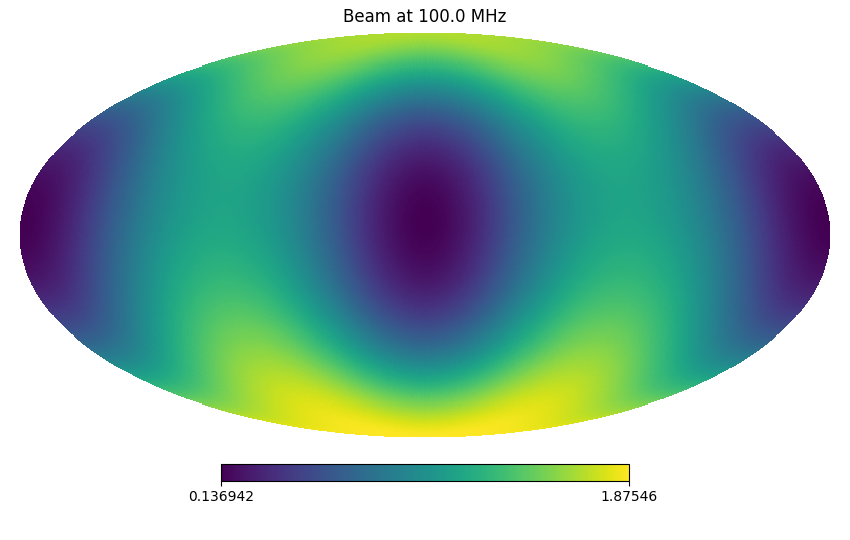

In [3]:
ix = 50
hp.mollview(beam[ix], title=f"Beam at {freqs[ix]} MHz")

114.0


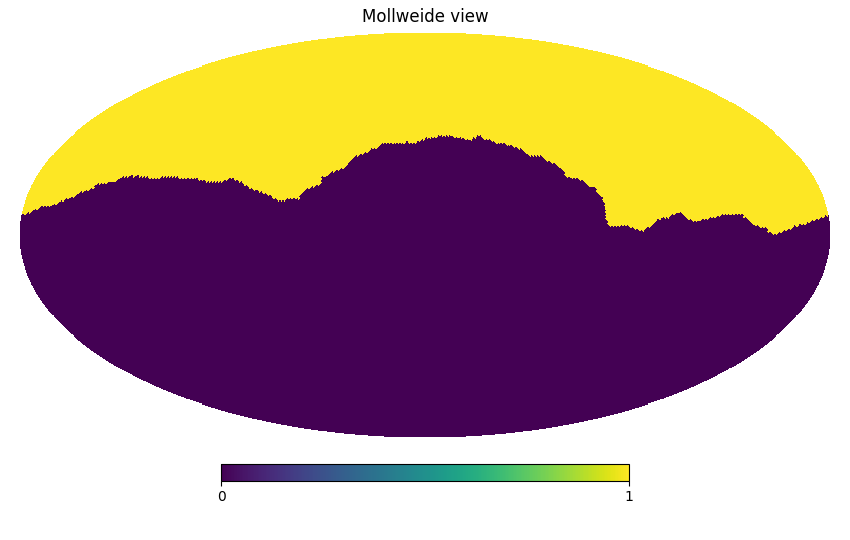

In [4]:
h = np.load("/home/christian/Documents/research/eigsep/eigsep_sims/horizon_models_v000.npz")
hix = -1
height = h["heights"][hix]
print(height)
r = h["r"][hix]
horizon = np.isnan(r)
hp.mollview(horizon)

In [5]:
beam.shape

(201, 49152)

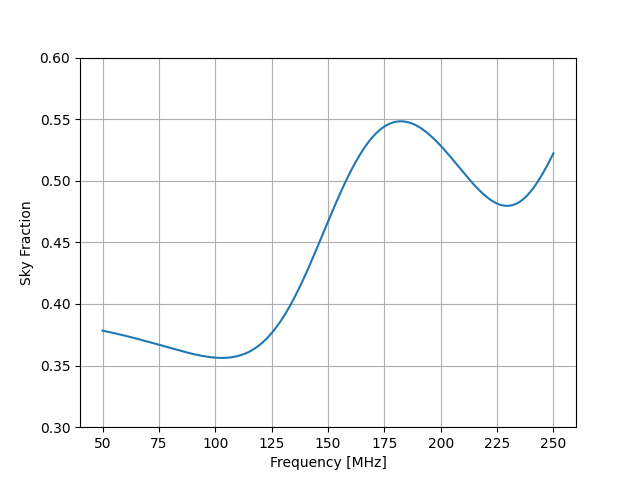

In [9]:
fsky = np.sum(beam * horizon[None], axis=1) / np.sum(beam, axis=1)

plt.figure()
plt.plot(freqs, fsky)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Sky Fraction")
plt.grid()
plt.ylim(0.3, 0.6)
plt.show()

In [4]:
lmax = 2*nside
beam_alm = np.array([hp.map2alm(bm, lmax=lmax, use_pixel_weights=True) for bm in beam])

In [5]:
def plot_alm(alm, ax=None, log=True):
    if not ax:
        plt.figure()
        ax = plt.gca()
        ax.grid()
    norm = np.abs(alm[0])
    ax.plot(np.abs(np.abs(alm)) / norm)
    if log:
        ax.set_yscale("log")
    return ax

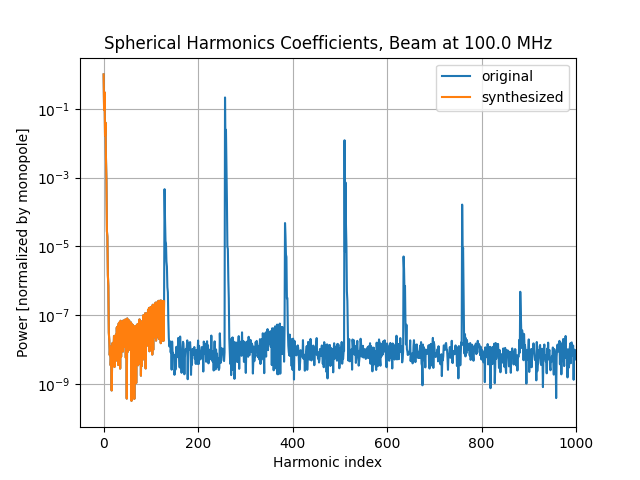

In [51]:
ax = plot_alm(beam_alm[50])
l = ax.lines[0]
l.set_label("original")
ax = plot_alm(beam_alm_zonal[50], ax=ax)
l = ax.lines[1]
l.set_label("synthesized")
ax.set_xlim(-50, 1000)
ax.set_xlabel("Harmonic index")
ax.set_ylabel("Power [normalized by monopole]")
ax.set_title(f"Spherical Harmonics Coefficients, Beam at {freqs[50]} MHz")
ax.legend()

128


(-100.0, 2500.0)

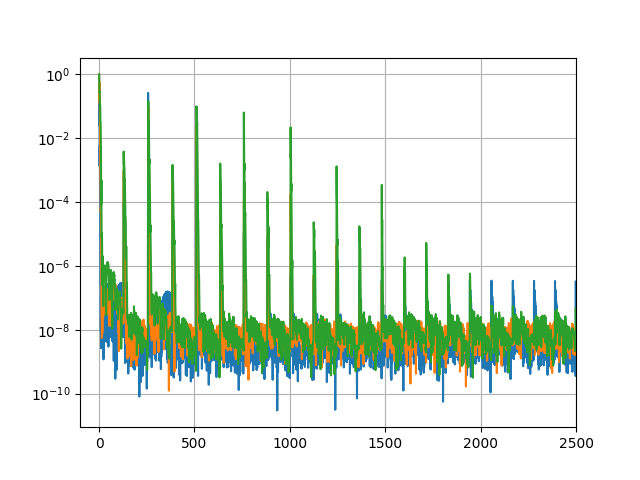

In [6]:
print(lmax)
ax = plot_alm(beam_alm[0])
ax = plot_alm(beam_alm[101], ax=ax)
ax = plot_alm(beam_alm[-1], ax=ax)
#ax.set_ylim(1e-4, 1)
ax.set_xlim(-100, 2500)

In [7]:
# azimuthal average
ell, emm = hp.Alm.getlm(lmax)
beam_alm_zonal = beam_alm[:, emm==0]

Text(0.5, 1.0, 'beam alm coefficients at different frequencies')

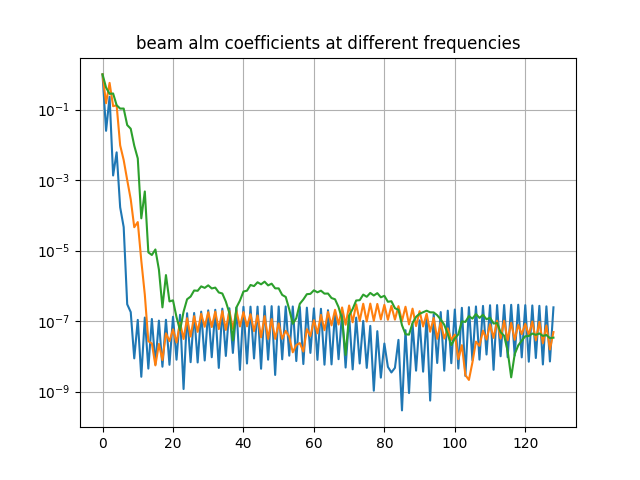

In [52]:
ax = plot_alm(beam_alm_zonal[0])
ax = plot_alm(beam_alm_zonal[101], ax=ax)
ax = plot_alm(beam_alm_zonal[-1], ax=ax)
ax.set_title("beam alm coefficients at different frequencies")

In [9]:
beam_zonal = hp.alm2map(beam_alm_zonal.copy(), nside, lmax=lmax, mmax=0, pol=False)

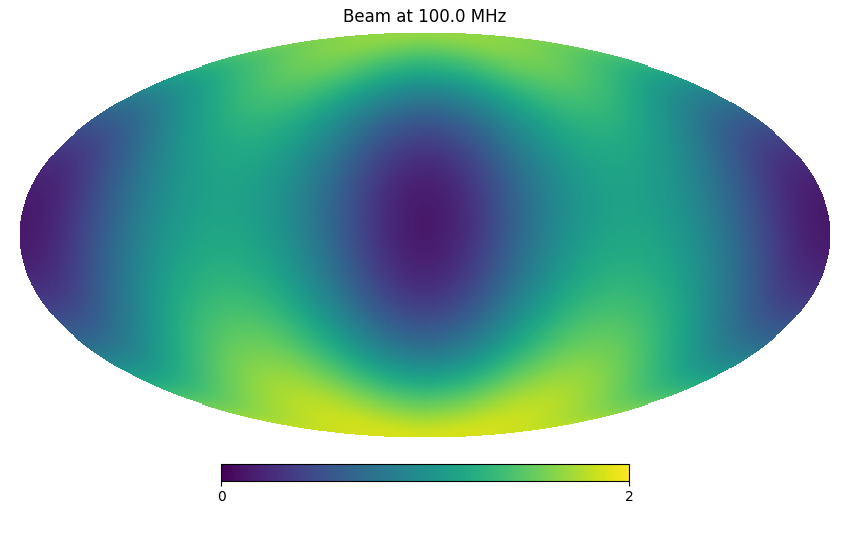

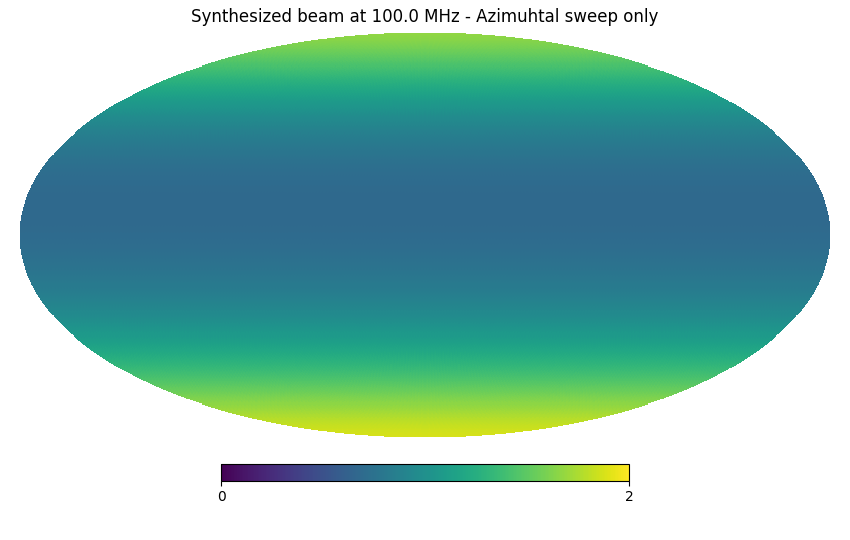

In [10]:
hp.mollview(beam[ix], title=f"Beam at {freqs[ix]} MHz", min=0, max=2)
hp.mollview(beam_zonal[ix], title=f"Synthesized beam at {freqs[ix]} MHz - Azimuhtal sweep only", min=0, max=2)

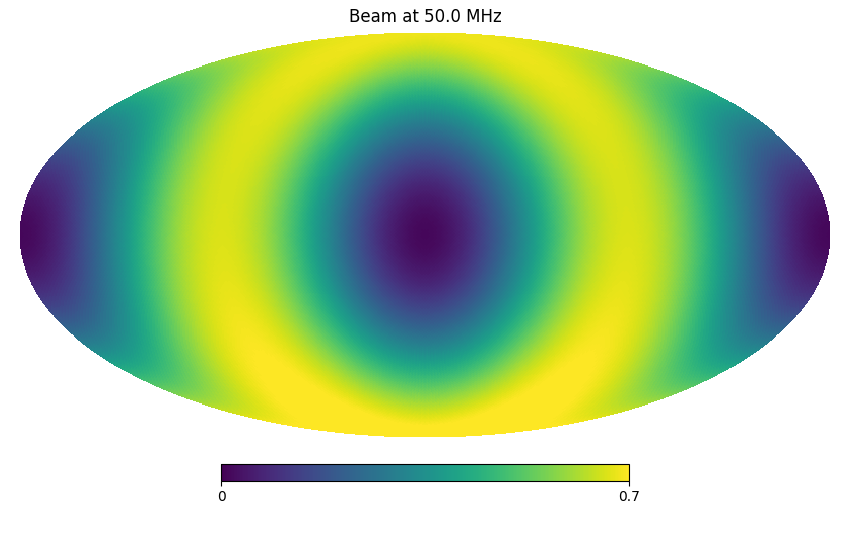

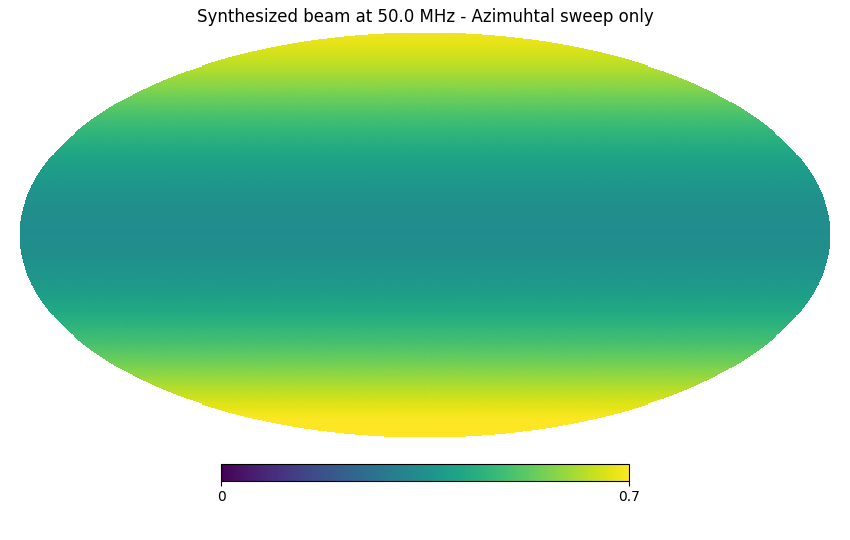

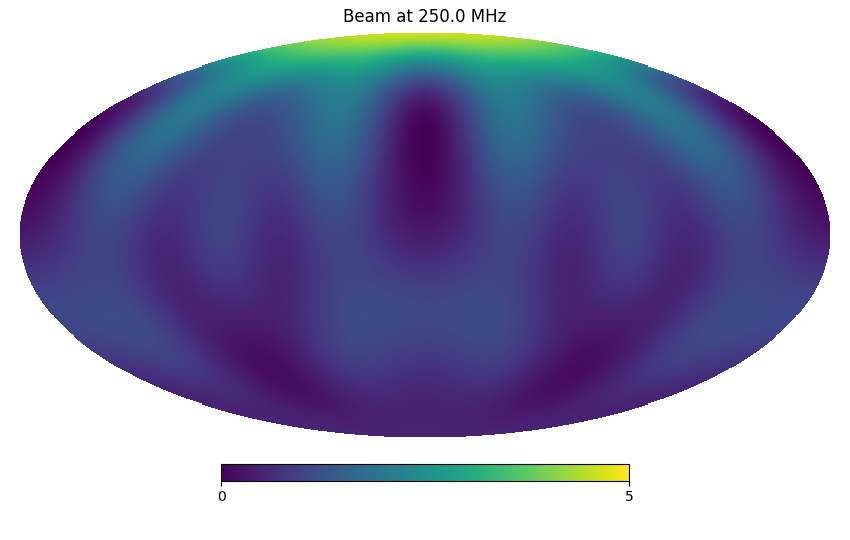

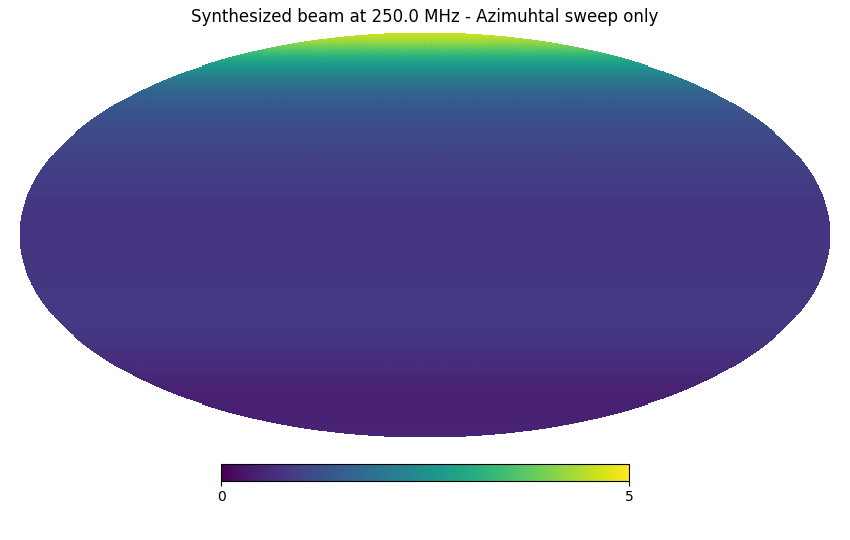

In [11]:
ix = 0
hp.mollview(beam[ix], title=f"Beam at {freqs[ix]} MHz", min=0, max=0.7)
hp.mollview(beam_zonal[ix], title=f"Synthesized beam at {freqs[ix]} MHz - Azimuhtal sweep only", min=0, max=0.7)

ix = -1
hp.mollview(beam[ix], title=f"Beam at {freqs[ix]} MHz", min=0, max=5)
hp.mollview(beam_zonal[ix], title=f"Synthesized beam at {freqs[ix]} MHz - Azimuhtal sweep only", min=0, max=5)

## What do the foregrounds look like?

In [12]:
import astropy.units as u
from astropy.coordinates import EarthLocation, AltAz, SkyCoord
from astropy.time import Time
from pathlib import Path

In [13]:
Ntimes = 200
offsets = np.linspace(0, 1, Ntimes, endpoint=False) * u.sday
times = Time("2026-02-05 20:48") + offsets

In [14]:
overwrite_sky = False
sky_path = Path("sky_topo.npy")
if overwrite_sky or not sky_path.exists():
    new_sky = True
else:
    new_sky = False
    sky_topo = np.load(sky_path)
    
# pixel centers for topocentric hp grid
npix = hp.nside2npix(nside)
theta_topo, phi_topo = hp.pix2ang(nside, np.arange(npix))
  
alt_topo = np.pi/2 - theta_topo
alt_topo = alt_topo * u.rad
az_topo  = phi_topo * u.rad

if new_sky:
    gsm = GlobalSkyModel16(freq_unit="MHz", data_unit="TRJ", resolution="lo", include_cmb=True)
    gsm_map = gsm.generate(freqs)
    hp.mollview(gsm_map[0])
    
    gsm_nside = hp.get_nside(gsm_map[0])
    gsm_npix = len(gsm_map[0])
    gal_lon, gal_lat = hp.pix2ang(gsm_nside, np.arange(gsm_npix), lonlat=True)
    
    LAT = 39.247699
    LON = -113.402660
    HGT = 1800 # m
    
    loc = EarthLocation(LON, LAT, HGT)
    obstimes = Time(times, format="jd")
    altaz = [AltAz(location=loc, obstime=t) for t in obstimes]

    
    # transform to altaz
    sky_topo = np.empty((len(times), len(freqs), npix), dtype=np.float32)
    for i, topo_frame in enumerate(altaz):
        sc_altaz = SkyCoord(alt=alt_topo, az=az_topo, frame=topo_frame)
        sc_gal = sc_altaz.transform_to("galactic")
        
        # nearest-neighbor interpolation
        pix = hp.ang2pix(gsm_nside, sc_gal.l.value, sc_gal.b.value, lonlat=True)
        sky_topo[i, :, :] = gsm_map[:, pix]

    np.save(sky_path, sky_topo)

/home/christian/Documents/research/eigsep/mock_analysis/.venv/lib/python3.12/site-packages/healpy/visufunc.py:200: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = pylab.figure(fig, figsize=(8.5, 5.4))


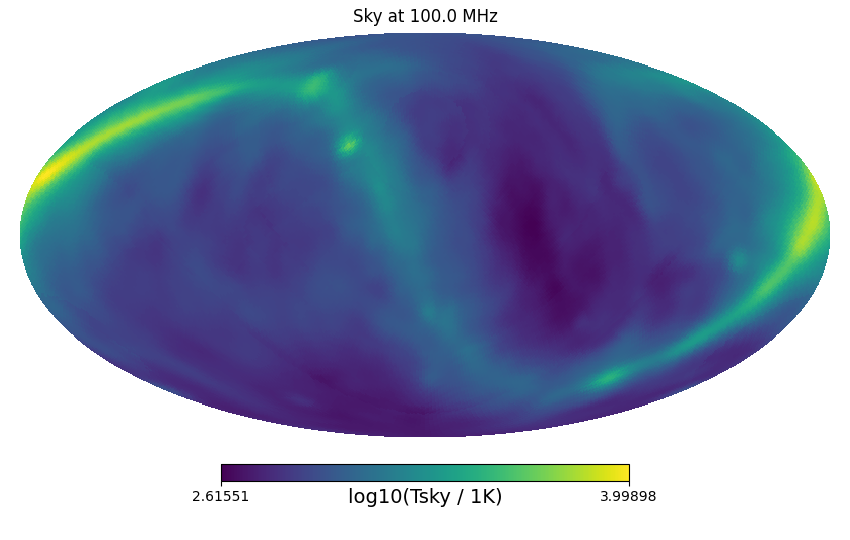

In [34]:
ix = 50
time_ix = 160
hp.mollview(np.log10(sky_topo[time_ix, ix]), title=f"Sky at {freqs[ix]} MHz", unit="log10(Tsky / 1K)")

In [16]:
sky_alm = np.array([hp.map2alm(s, lmax=lmax, use_pixel_weights=True) for s in sky_topo[time_ix]])

In [45]:
ax.lines[0]

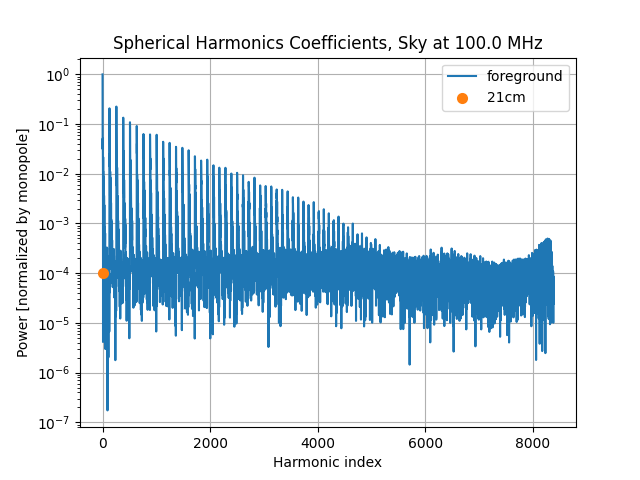

In [46]:
ax = plot_alm(sky_alm[50])
l = ax.lines[0]
l.set_label("foreground")
ax.scatter(0, 1e-4, c="C1", lw=2, zorder=10, label="21cm")
ax.set_xlabel("Harmonic index")
ax.set_ylabel("Power [normalized by monopole]")
ax.set_title(f"Spherical Harmonics Coefficients, Sky at {freqs[50]} MHz")
ax.legend()

128


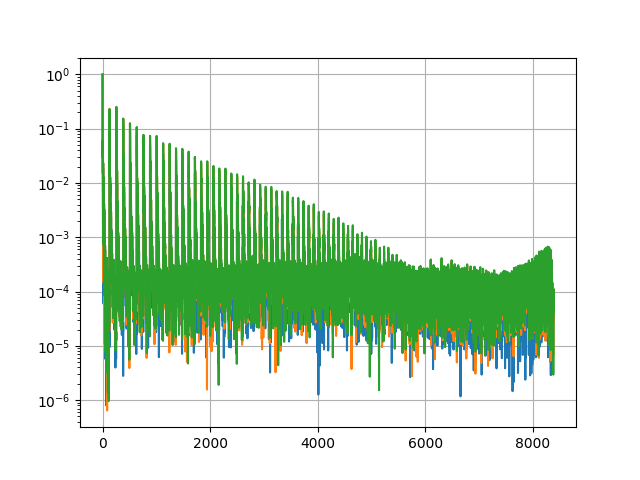

In [17]:
print(lmax)
ax = plot_alm(sky_alm[0])
ax = plot_alm(sky_alm[101], ax=ax)
ax = plot_alm(sky_alm[-1], ax=ax)
#ax.set_ylim(1e-4, 1)
#ax.set_xlim(-100, 2500)

Sky has significant power at many angular scales.

But beam is only sensitive to its own modes, so we can restrict to m=0.

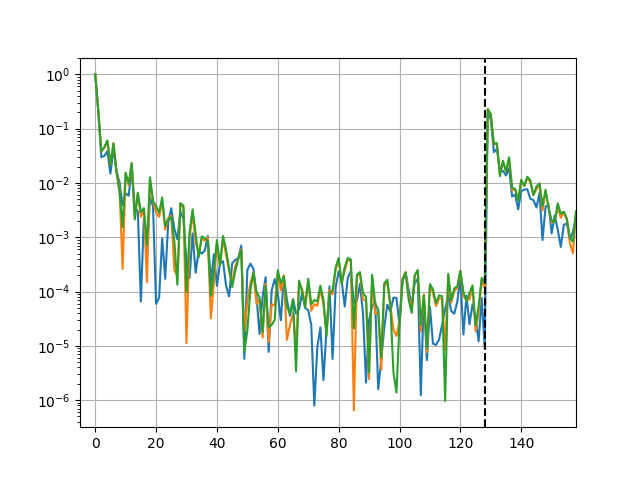

In [18]:
ax = plot_alm(sky_alm[0])
ax = plot_alm(sky_alm[101], ax=ax)
ax = plot_alm(sky_alm[-1], ax=ax)
ax.set_xlim(-5, lmax+30)
ax.axvline(lmax, ls="--", c="k")

## Horizon

Naively, you'd think the global signal is just the monopole, so a strategy for spatial foreground filtering is figuring out how to rotate the antenna in ways that average out all modes other than l=0, m=0. Issue is the horizon which spreads 21cm signal to all modes.

114.0


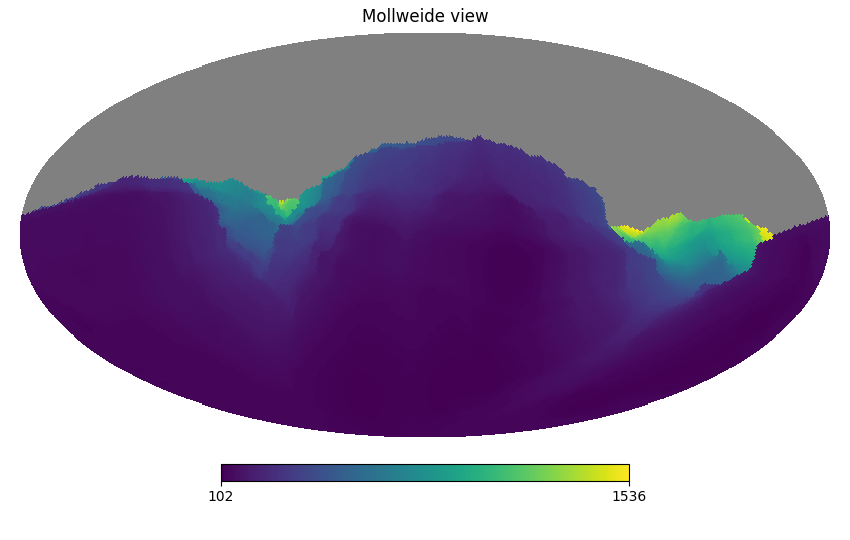

In [19]:
h = np.load("/home/christian/Documents/research/eigsep/eigsep_sims/horizon_models_v000.npz")
hix = -1
height = h["heights"][hix]
print(height)
r = h["r"][hix]
hp.mollview(r)

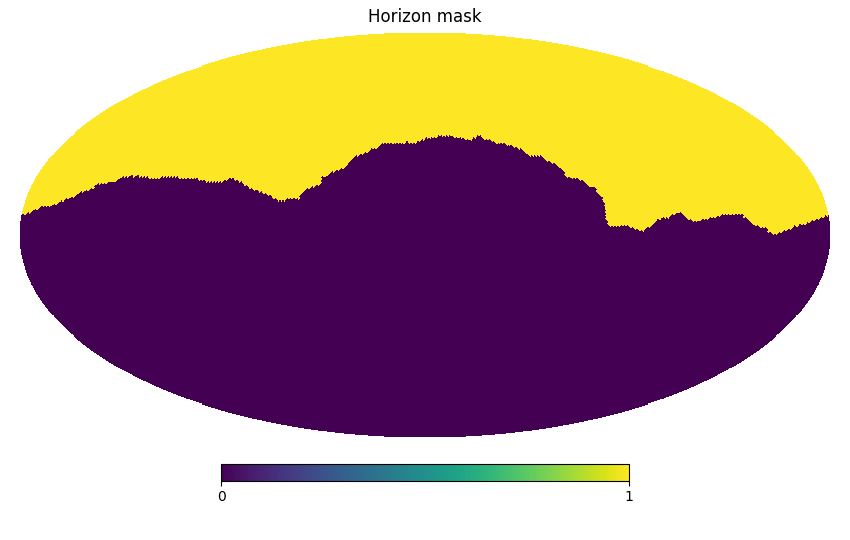

In [54]:
horizon = np.isnan(r)
hp.mollview(horizon, title="Horizon mask")

h_alm = hp.map2alm(horizon, lmax=lmax, use_pixel_weights=True)

In [67]:
sky_alm_h = np.array([hp.map2alm(s*horizon + 0 * (1-horizon), lmax=lmax, use_pixel_weights=True) for s in sky_topo[time_ix]])

In [68]:
h21 = hp.map2alm(0.1*horizon + 0 * (1-horizon), lmax=lmax, use_pixel_weights=True)

In [71]:
o21 = hp.map2alm(0.1*np.ones_like(horizon), lmax=lmax, use_pixel_weights=True)

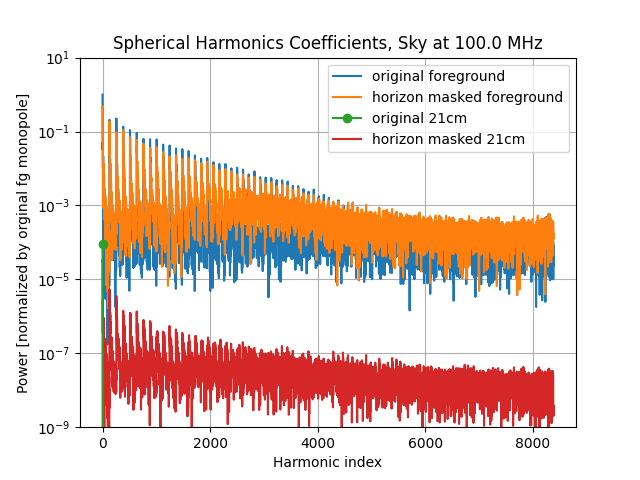

In [77]:
ax = plot_alm(sky_alm[50])
l = ax.lines[0]
l.set_label("original foreground")
#ax = plot_alm(sky_alm_h[50], ax=ax)
ax.plot(np.abs(sky_alm_h[50])/np.abs(sky_alm[50][0]), label="horizon masked foreground", c="C1", ls="-")
#ax.scatter(0, 1e-4, c="k", lw=2, zorder=100, label="original 21cm")
ax.plot(np.abs(o21)/np.abs(sky_alm[50][0]), label="original 21cm", c="C2", zorder=100, marker="o")
ax.plot(np.abs(h21)/np.abs(sky_alm[50][0]), label="horizon masked 21cm", c="C3")

ax.set_ylim(1e-9, 1e1)

ax.set_xlabel("Harmonic index")
ax.set_ylabel("Power [normalized by orginal fg monopole]")
ax.set_title(f"Spherical Harmonics Coefficients, Sky at {freqs[50]} MHz")
ax.legend()

In [26]:
#h16 = hp.ud_grade(horizon, 16)
#np.savez("/home/christian/Documents/research/eigsep/eigsep_sims/horizon.npz", horizon=h16)

Text(0.5, 1.0, 'Horizon spherical harmonics decomposition')

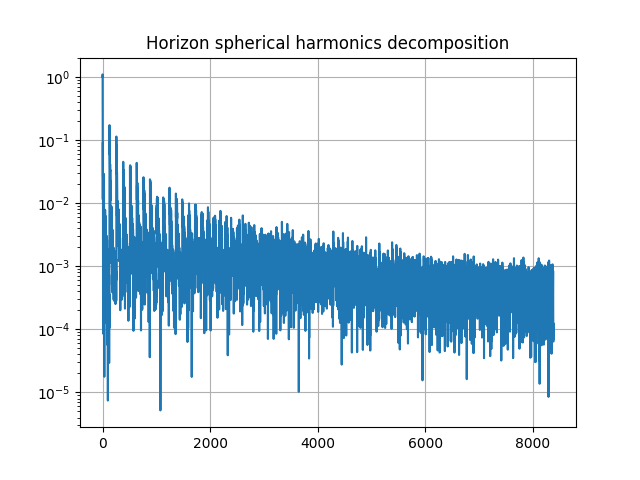

In [55]:
ax = plot_alm(h_alm, log=True)
ax.set_title("Horizon spherical harmonics decomposition")

This is exactly the same pattern (just flipped north-south) that the horizon-masked monopole sky has.

An azimuth average would incur 21-cm signal loss.

7.985054809489944


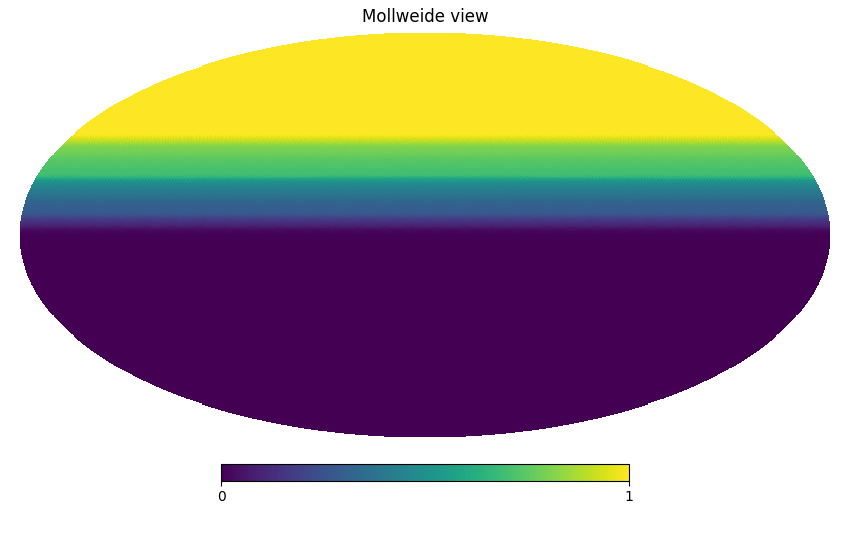

In [31]:
hz = hp.alm2map(h_alm[:lmax+1], nside, lmax=lmax, mmax=0, pol=False)
loss = np.sum(np.abs(h_alm[lmax+1:])**2) / np.sum(np.abs(h_alm)**2)
print(loss*1e2)

hp.mollview(hz, min=0, max=1)

In [78]:
# what if we were able to filter all modes?
print(np.sum(np.abs(h_alm[1:])) / np.sum(np.abs(h_alm)))

0.9405978900389707
